In [1]:
from sys import path
path.append('../tools')
from tools import gen_inputs_outputs, gen_pair_inputs
from tensorflow import keras
from keras import layers, Sequential, Input, metrics
import matplotlib.pyplot as plt

2024-07-23 10:07:59.104248: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-23 10:08:00.889696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 10:08:01.533499: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 10:08:01.536201: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 10:08:02.534264: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# For these calculations, we change the input so that
# the layers are in units of 2

In [3]:
R = 16
x_train, y_train, S = gen_inputs_outputs(R)
x_train = gen_pair_inputs(x_train)

In [4]:
# Creates the unit inputs
def gen_unit_inputs(l):
    return [Input(shape=(2,), name=f'unit_{i}') for i in range(l)]

# Create the units
## Using biases on units has large positive impact on performance
def gen_units(unit_inputs, size, activation, use_biases=True):
    return [layers.Dense(size,
                         activation=activation,
                         use_bias=use_biases,
                         name=f'dense_unit_{i}')(unit_input) for i, unit_input in enumerate(unit_inputs)]

# Concatenate layer of units in pairs return
# layer of units with each of size size
## Using biases on units has large positive impact on performance
def reduce_units(units, size, activation, use_biases=True):
    # Create empty list for new units
    paired_units = [None] * int(len(units) / 2)
    
    # Fill the list with concatenated units (necessary before dense layer)
    for i in range(0, len(units), 2):
        paired_units[int(i/2)] = layers.concatenate(units[i:i+2])
    
    # Return dense layer of size on the concatenated layer
    return [layers.Dense(size, 
                         activation=activation,
                         use_bias=use_biases,
                         name=f'reducer_unit_{i}')(paired_units[i]) for i in range(len(paired_units))]
        

In [5]:
# First model that we are testing
# Chose whether or not to use biases
def create_model_1(plot_model=False, model_name='model1'):
    # Create the inputs
    inputs = gen_unit_inputs(len(x_train))

    # Create the units
    x = layers.concatenate(gen_units(inputs, 2, activation='relu', use_biases=True))
    
    # Add dense layers
    x = layers.Dense(64, activation='relu', use_bias=True, name='hidden_dense_1')(x)

    # Ouput layer
    outputs = layers.Dense(S, activation='sigmoid', use_bias=True, name='ouput')(x)

    model = keras.Model(
        inputs=inputs,
        outputs=outputs
    )
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [6]:
# Plots the binary accuracy of a model
def plot_history(history, name):
    # Create x axis so that it starts at 1 (and not 0)
    # This is not noticeable for large eopchs
    x_points = [i for i in range(1, EPOCHS+1)]

    plt.plot(x_points, history.history['binary_accuracy'], label='Binary Accuracy')
    plt.title(f'{name}: Binary Accuracy')
    plt.legend(loc='lower right')

    plt.show()

In [7]:
# Create first model
model1 = create_model_1(plot_model=True)

# Compile and train the moded
OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 1000
BATCH_SIZE = 512

model1.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)


history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

## Batch size 512 with dense layer at 64: converges to aroud 0.833

2024-07-23 10:08:16.588249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-23 10:08:18.212120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-23 10:08:18.212662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/1000


I0000 00:00:1721722103.008369    5283 service.cc:145] XLA service 0x77eea8011b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721722103.008461    5283 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-23 10:08:24.202349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-23 10:08:25.187116: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - binary_accuracy: 0.5176 - loss: 0.6941
Epoch 2/1000


I0000 00:00:1721722108.349368    5283 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.5913 - loss: 0.6607
Epoch 3/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.6336 - loss: 0.6165
Epoch 4/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.6707 - loss: 0.5681
Epoch 5/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.6948 - loss: 0.5262
Epoch 6/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - binary_accuracy: 0.7143 - loss: 0.4903
Epoch 7/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.7323 - loss: 0.4610
Epoch 8/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.7482 - loss: 0.4367
Epoch 9/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.7569 - loss: 0.4162
Epoch 10/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.7626 - loss: 0.3974
Epoch 11/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.7652 - loss: 0.3844
Epoch 12/1000
128/128 ━━━━━━━━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - binary_accuracy: 0.8595 - loss: 0.2392
Epoch 65/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8596 - loss: 0.2384
Epoch 66/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.8598 - loss: 0.2376
Epoch 67/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8603 - loss: 0.2374
Epoch 68/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8606 - loss: 0.2363
Epoch 69/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8606 - loss: 0.2357
Epoch 70/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8607 - loss: 0.2344
Epoch 71/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8630 - loss: 0.2336
Epoch 72/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - binary_accuracy: 0.8634 - loss: 0.2333
Epoch 73/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.8637 - loss: 0.2320
Epoch 74/1000
128/128 ━━━━━━━━━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - binary_accuracy: 0.8870 - loss: 0.2063
Epoch 126/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8875 - loss: 0.2062
Epoch 127/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8888 - loss: 0.2050
Epoch 128/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - binary_accuracy: 0.8879 - loss: 0.2060
Epoch 129/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8887 - loss: 0.2058
Epoch 130/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - binary_accuracy: 0.8881 - loss: 0.2059
Epoch 131/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - binary_accuracy: 0.8881 - loss: 0.2059
Epoch 132/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - binary_accuracy: 0.8883 - loss: 0.2059
Epoch 133/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - binary_accuracy: 0.8882 - loss: 0.2047
Epoch 134/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - binary_accuracy: 0.8889 - loss: 0.2054
Epoch 135/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - binary_accuracy: 0.8894 - loss: 0.2024
Epoch 187/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8892 - loss: 0.2029
Epoch 188/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8891 - loss: 0.2029
Epoch 189/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - binary_accuracy: 0.8889 - loss: 0.2036
Epoch 190/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8891 - loss: 0.2028
Epoch 191/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8893 - loss: 0.2022
Epoch 192/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - binary_accuracy: 0.8890 - loss: 0.2027
Epoch 193/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8885 - loss: 0.2028
Epoch 194/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - binary_accuracy: 0.8896 - loss: 0.2020
Epoch 195/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8895 - loss: 0.2016
Epoch 196/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8890 - loss: 0.2029
Epoch 248/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8899 - loss: 0.2012
Epoch 249/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - binary_accuracy: 0.8893 - loss: 0.2018
Epoch 250/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.8889 - loss: 0.2023
Epoch 251/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8897 - loss: 0.2013
Epoch 252/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8890 - loss: 0.2012
Epoch 253/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8895 - loss: 0.2022
Epoch 254/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - binary_accuracy: 0.8891 - loss: 0.2024
Epoch 255/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - binary_accuracy: 0.8891 - loss: 0.2016
Epoch 256/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - binary_accuracy: 0.8892 - loss: 0.2021
Epoch 257/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8898 - loss: 0.2016
Epoch 309/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8888 - loss: 0.2023
Epoch 310/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8897 - loss: 0.2013
Epoch 311/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - binary_accuracy: 0.8896 - loss: 0.2021
Epoch 312/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8900 - loss: 0.2009
Epoch 313/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8897 - loss: 0.2017
Epoch 314/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8893 - loss: 0.2012
Epoch 315/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8892 - loss: 0.2018
Epoch 316/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8896 - loss: 0.2016
Epoch 317/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8886 - loss: 0.2024
Epoch 318/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8892 - loss: 0.2016
Epoch 370/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8902 - loss: 0.2009
Epoch 371/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - binary_accuracy: 0.8896 - loss: 0.2017
Epoch 372/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - binary_accuracy: 0.8903 - loss: 0.2003
Epoch 373/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8896 - loss: 0.2010
Epoch 374/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8889 - loss: 0.2017
Epoch 375/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.8905 - loss: 0.2003
Epoch 376/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8896 - loss: 0.2014
Epoch 377/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8897 - loss: 0.2015
Epoch 378/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8888 - loss: 0.2018
Epoch 379/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - binary_accuracy: 0.8894 - loss: 0.2012
Epoch 431/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8892 - loss: 0.2016
Epoch 432/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8897 - loss: 0.2010
Epoch 433/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8895 - loss: 0.2007
Epoch 434/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8891 - loss: 0.2010
Epoch 435/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8896 - loss: 0.2007
Epoch 436/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8898 - loss: 0.2011
Epoch 437/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8898 - loss: 0.2005
Epoch 438/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8890 - loss: 0.2018
Epoch 439/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8895 - loss: 0.2005
Epoch 440/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - binary_accuracy: 0.8892 - loss: 0.2014
Epoch 492/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - binary_accuracy: 0.8888 - loss: 0.2014
Epoch 493/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8894 - loss: 0.2012
Epoch 494/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - binary_accuracy: 0.8881 - loss: 0.2023
Epoch 495/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8892 - loss: 0.2011
Epoch 496/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8886 - loss: 0.2013
Epoch 497/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - binary_accuracy: 0.8905 - loss: 0.2000
Epoch 498/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - binary_accuracy: 0.8900 - loss: 0.2006
Epoch 499/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8893 - loss: 0.2008
Epoch 500/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - binary_accuracy: 0.8904 - loss: 0.2002
Epoch 501/1000
128/128 ━━━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8888 - loss: 0.2016
Epoch 553/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8886 - loss: 0.2009
Epoch 554/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8898 - loss: 0.2006
Epoch 555/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8901 - loss: 0.2006
Epoch 556/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8898 - loss: 0.2006
Epoch 557/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8895 - loss: 0.2016
Epoch 558/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - binary_accuracy: 0.8898 - loss: 0.2005
Epoch 559/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - binary_accuracy: 0.8891 - loss: 0.2013
Epoch 560/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - binary_accuracy: 0.8905 - loss: 0.2002
Epoch 561/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8893 - loss: 0.2008
Epoch 562/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8901 - loss: 0.2002
Epoch 614/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8888 - loss: 0.2014
Epoch 615/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8894 - loss: 0.2014
Epoch 616/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8894 - loss: 0.2014
Epoch 617/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - binary_accuracy: 0.8897 - loss: 0.2003
Epoch 618/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8904 - loss: 0.2003
Epoch 619/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - binary_accuracy: 0.8905 - loss: 0.1994
Epoch 620/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8903 - loss: 0.2005
Epoch 621/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8903 - loss: 0.2004
Epoch 622/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - binary_accuracy: 0.8906 - loss: 0.1999
Epoch 623/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8899 - loss: 0.2000
Epoch 675/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8893 - loss: 0.2007
Epoch 676/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - binary_accuracy: 0.8893 - loss: 0.2009
Epoch 677/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8894 - loss: 0.2010
Epoch 678/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8888 - loss: 0.2007
Epoch 679/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8893 - loss: 0.2013
Epoch 680/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8898 - loss: 0.2009
Epoch 681/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8892 - loss: 0.2010
Epoch 682/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8896 - loss: 0.2011
Epoch 683/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8889 - loss: 0.2015
Epoch 684/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8900 - loss: 0.2005
Epoch 736/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8898 - loss: 0.2001
Epoch 737/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8904 - loss: 0.1999
Epoch 738/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8902 - loss: 0.2005
Epoch 739/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8896 - loss: 0.2009
Epoch 740/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8903 - loss: 0.2001
Epoch 741/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - binary_accuracy: 0.8898 - loss: 0.2006
Epoch 742/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8905 - loss: 0.1995
Epoch 743/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8899 - loss: 0.2004
Epoch 744/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8899 - loss: 0.2001
Epoch 745/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8894 - loss: 0.2010
Epoch 797/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - binary_accuracy: 0.8902 - loss: 0.2001
Epoch 798/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - binary_accuracy: 0.8892 - loss: 0.2005
Epoch 799/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.8895 - loss: 0.2007
Epoch 800/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8892 - loss: 0.2001
Epoch 801/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - binary_accuracy: 0.8892 - loss: 0.2008
Epoch 802/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - binary_accuracy: 0.8904 - loss: 0.2003
Epoch 803/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8879 - loss: 0.2018
Epoch 804/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8895 - loss: 0.2007
Epoch 805/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - binary_accuracy: 0.8891 - loss: 0.2011
Epoch 806/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8888 - loss: 0.2011
Epoch 858/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - binary_accuracy: 0.8898 - loss: 0.2005
Epoch 859/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8890 - loss: 0.2007
Epoch 860/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8906 - loss: 0.2003
Epoch 861/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8897 - loss: 0.2004
Epoch 862/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8892 - loss: 0.2009
Epoch 863/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - binary_accuracy: 0.8896 - loss: 0.2007
Epoch 864/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8896 - loss: 0.2004
Epoch 865/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8905 - loss: 0.2002
Epoch 866/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - binary_accuracy: 0.8897 - loss: 0.2006
Epoch 867/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8887 - loss: 0.2007
Epoch 919/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8896 - loss: 0.2004
Epoch 920/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8903 - loss: 0.2002
Epoch 921/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8897 - loss: 0.2007
Epoch 922/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.8895 - loss: 0.2007
Epoch 923/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8898 - loss: 0.2000
Epoch 924/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - binary_accuracy: 0.8896 - loss: 0.2008
Epoch 925/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8904 - loss: 0.1995
Epoch 926/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8900 - loss: 0.2002
Epoch 927/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - binary_accuracy: 0.8898 - loss: 0.2006
Epoch 928/1000
128/128 ━━

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - binary_accuracy: 0.8899 - loss: 0.2004
Epoch 980/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8912 - loss: 0.1999
Epoch 981/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - binary_accuracy: 0.8896 - loss: 0.2005
Epoch 982/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8903 - loss: 0.2010
Epoch 983/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - binary_accuracy: 0.8893 - loss: 0.2006
Epoch 984/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - binary_accuracy: 0.8900 - loss: 0.2007
Epoch 985/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.8903 - loss: 0.2003
Epoch 986/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - binary_accuracy: 0.8896 - loss: 0.2006
Epoch 987/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.8897 - loss: 0.2008
Epoch 988/1000
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - binary_accuracy: 0.8887 - loss: 0.2012
Epoch 989/1000
128/128 ━━

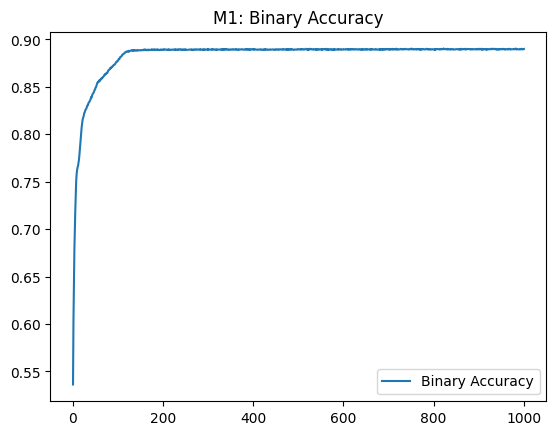

In [8]:
plot_history(history, 'M1')

In [9]:
# Second model : does an extra unit reduction
def create_model_2(hidden_dense_1_size=256, plot_model=False, model_name='model2'):
    # Create the input units
    inputs = gen_unit_inputs(len(x_train))
    
    # Create the units on the inputs
    x = gen_units(inputs, size=2, activation='relu')
    
    # Unit reduction to size 3
    x = layers.concatenate(reduce_units(x, size=3, activation='relu'))
    
    # Hidden dense layer
    x = layers.Dense(hidden_dense_1_size, activation='relu', name='hidden_dense_1')(x)
    
    # Output layer
    outputs = layers.Dense(S, activation='sigmoid', name='output')(x)
    
    # Create the model
    model = keras.Model(inputs=inputs,
                        outputs=outputs)
    
    # Plot the model if specified
    if plot_model:
        keras.utils.plot_model(
            model,
            show_shapes=True,
            show_layer_names=True,
            show_layer_activations=True,
            to_file=f'{model_name}.png',
        )
    
    # Return the model
    return model

In [ ]:
## Take results with a pinch of salt, can be very variable
## Train gets more gradual the lower the size
## Ran on 512 epochs
## Sizes with error: 16 (0.6984), 32 (0.8699), 64 (0.8585), 128 (0.8697), 256 (0.8330), 512 (0.80), 1024 (0.8673)
model2 = create_model_2(hidden_dense_1_size=32, plot_model=True)

OPTIMIZER = 'adam'
LOSS = 'binary_crossentropy'
METRICS = ['binary_accuracy']

EPOCHS = 500
BATCH_SIZE = 512 
## Doesn't change convergence much deteriorates after 512. 
## Curve gets a lot steeper with higher batch size.
## Makes sense as then epoch size needs to increase for
## to reach convergence
## Huge impact on speed

model2.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS,
)

history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
)

Epoch 1/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.5100 - loss: 0.6931
Epoch 2/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.5747 - loss: 0.6753
Epoch 3/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6131 - loss: 0.6251
Epoch 4/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6349 - loss: 0.5863
Epoch 5/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.6735 - loss: 0.5461
Epoch 6/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7004 - loss: 0.5038
Epoch 7/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7065 - loss: 0.4763
Epoch 8/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7117 - loss: 0.4617
Epoch 9/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7186 - loss: 0.4521
Epoch 10/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7189 - loss: 0.4462
Epoch 11/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - bin

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8276 - loss: 0.2808
Epoch 65/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8268 - loss: 0.2817
Epoch 66/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8270 - loss: 0.2802
Epoch 67/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8275 - loss: 0.2801
Epoch 68/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8266 - loss: 0.2805
Epoch 69/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8271 - loss: 0.2797
Epoch 70/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8266 - loss: 0.2797
Epoch 71/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8272 - loss: 0.2795
Epoch 72/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8276 - loss: 0.2786
Epoch 73/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8272 - loss: 0.2792
Epoch 74/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8319 - loss: 0.2712
Epoch 128/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8327 - loss: 0.2705
Epoch 129/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8320 - loss: 0.2708
Epoch 130/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8327 - loss: 0.2707
Epoch 131/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8328 - loss: 0.2705
Epoch 132/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8322 - loss: 0.2707
Epoch 133/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8329 - loss: 0.2699
Epoch 134/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8336 - loss: 0.2708
Epoch 135/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8336 - loss: 0.2693
Epoch 136/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8337 - loss: 0.2700
Epoch 137/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8373 - loss: 0.2658
Epoch 191/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8375 - loss: 0.2657
Epoch 192/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8364 - loss: 0.2669
Epoch 193/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8365 - loss: 0.2661
Epoch 194/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8367 - loss: 0.2661   
Epoch 195/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8372 - loss: 0.2658
Epoch 196/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8376 - loss: 0.2659
Epoch 197/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8372 - loss: 0.2666
Epoch 198/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8380 - loss: 0.2656
Epoch 199/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8372 - loss: 0.2663
Epoch 200/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8399 - loss: 0.2632
Epoch 254/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8412 - loss: 0.2627
Epoch 255/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8400 - loss: 0.2635
Epoch 256/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8412 - loss: 0.2630
Epoch 257/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8403 - loss: 0.2629
Epoch 258/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8404 - loss: 0.2628
Epoch 259/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8420 - loss: 0.2619
Epoch 260/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8399 - loss: 0.2632
Epoch 261/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8417 - loss: 0.2619
Epoch 262/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8423 - loss: 0.2616
Epoch 263/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8452 - loss: 0.2584
Epoch 317/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - binary_accuracy: 0.8464 - loss: 0.2576
Epoch 318/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - binary_accuracy: 0.8445 - loss: 0.2596
Epoch 319/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8448 - loss: 0.2580
Epoch 320/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8444 - loss: 0.2588
Epoch 321/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8451 - loss: 0.2583
Epoch 322/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8456 - loss: 0.2581
Epoch 323/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8455 - loss: 0.2581
Epoch 324/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8451 - loss: 0.2579
Epoch 325/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8453 - loss: 0.2583
Epoch 326/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8465 - loss: 0.2562
Epoch 380/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8468 - loss: 0.2561
Epoch 381/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8478 - loss: 0.2550
Epoch 382/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8469 - loss: 0.2557
Epoch 383/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8483 - loss: 0.2546
Epoch 384/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8479 - loss: 0.2547
Epoch 385/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8474 - loss: 0.2551
Epoch 386/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8471 - loss: 0.2555
Epoch 387/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8478 - loss: 0.2554
Epoch 388/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8478 - loss: 0.2549
Epoch 389/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8505 - loss: 0.2535
Epoch 443/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8501 - loss: 0.2525
Epoch 444/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8497 - loss: 0.2528
Epoch 445/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8504 - loss: 0.2521
Epoch 446/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8503 - loss: 0.2526
Epoch 447/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8493 - loss: 0.2532
Epoch 448/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8507 - loss: 0.2527
Epoch 449/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8498 - loss: 0.2530
Epoch 450/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8508 - loss: 0.2521
Epoch 451/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8504 - loss: 0.2527
Epoch 452/500
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [ ]:
plot_history(history, 'M2')

In [ ]:
# Add more dense layers after the unit reduction
# Add an extra unit reduction to go from last layer of size 3
# to last layer of size 2